## Problem Set #[5]
MACS 30150, Dr. Evans

Linghui Wu

### Question 1

In [1]:
# Import the necessary packages
import numpy as np 
import pandas as pd
import numpy.linalg as lin 
import scipy.stats as sts 
import scipy.integrate as intgr 
import scipy.optimize as opt 
import matplotlib.pyplot as plt 
import warnings 
warnings.filterwarnings("ignore")

#### (a)

In [2]:
# Load the income data as NumPy array
incomes = np.loadtxt("data/incomes.txt")
incomes

array([ 53711.54439888,  99731.23334901,  84773.60541676,  75184.025931  ,
        73390.9559334 ,  77276.56474964,  82597.32702898,  76098.11372822,
        91850.97696668,  71750.0904012 ,  78839.14719934,  76488.842497  ,
        98425.21508839,  89179.46995662,  69270.14146077,  98745.58813476,
        99678.12106606, 130562.89791757,  96611.47162489, 107722.74557525,
        89815.6930569 ,  64096.00766797, 100953.33883423, 139079.35154872,
        56620.60756267,  93887.32671771,  54443.1018241 ,  72214.43571941,
        85334.16381855,  78259.71280733,  83023.40314506,  88219.63714926,
        87329.86039444,  89740.87145837,  71486.02524282,  55951.62544771,
        66967.80460396,  85265.54454384, 126226.62999114, 110291.25329238,
        81804.83284175,  72162.4456693 ,  68229.92749973,  86750.35322317,
       118823.56074404, 108877.93206918,  64915.4289308 , 100934.6283851 ,
        64519.54919916,  65975.57876619, 111441.88321069,  68291.50073029,
        65405.50677863,  

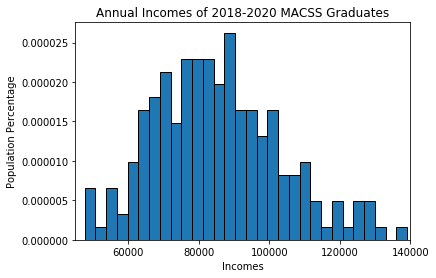

In [3]:
# Plot the histogram
num_bins = 30
count, bins, ignored = plt.hist(incomes, num_bins, density=True, edgecolor="k")
plt.title("Annual Incomes of 2018-2020 MACSS Graduates")
plt.xlabel(r"Incomes")
plt.ylabel(r"Population Percentage")
plt.xlim([45000, 140000]);

#### (b)

In [4]:
# Define a truncated lognormal function that generates value of a lognormal pdf
def trunc_lognormal_pdf(xvals, mu, sigma, cut_lb, cut_ub):
    if cut_ub == "None" and cut_lb == "None":
        prob_not_cut = 1.0
    elif cut_ub == "None" and cut_lb != "None":
        prob_not_cut = 1.0 - sts.lognorm.cdf(cut_lb, s=sigma, scale=np.exp(mu))
    elif cut_ub != "None" and cut_lb == "None":
        prob_not_cut = sts.lognorm.cdf(cut_ub, s=sigma, scale=np.exp(mu))
    elif cut_ub != "None" and cut_lb != "None":
        prob_not_cut = sts.lognorm.cdf(cut_ub, s=sigma, scale=np.exp(mu)) - \
                        sts.lognorm.cdf(cut_lb, s=sigma, scale=np.exp(mu))

    pdf_vals = (1 / prob_not_cut) * 1 / (xvals * sigma * np.sqrt(2 * np.pi)) * \
                np.exp(- (np.log(xvals) - mu) ** 2 / (2 * sigma ** 2))
    return pdf_vals

In [5]:
# Define a function that computes the two data moments for GMM
def data_moments(xvals):
    mean_data = xvals.mean()
    std_data = xvals.std()
    return mean_data, std_data

In [6]:
# Define a function that computes the two model moments for GMM
def model_moments(mu, sigma, cut_lb, cut_ub):
    xfx = lambda x: x * trunc_lognormal_pdf(x, mu, sigma, cut_lb, cut_ub)
    mean_model, m_m_err = intgr.quad(xfx, cut_lb, cut_ub)
    x2fx = lambda x: (x - mean_model) ** 2 * trunc_lognormal_pdf(x, mu, sigma, cut_lb, cut_ub)
    var_model, v_m_err = intgr.quad(x2fx, cut_lb, cut_ub) 
    return mean_model, np.sqrt(var_model)

In [7]:
# Define the moment error function
def err_vec(xvals, mu, sigma, cut_lb, cut_ub, simple):
    mean_data, std_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [std_data]])
    mean_model, std_model = model_moments(mu, sigma, cut_lb, cut_ub)
    moms_model = np.array([[mean_model], [std_model]])
    
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    return err_vec

In [8]:
# Define the criterion function
def criterion(params, *args):
    mu, sigma = params
    xvals, cub_lb, cut_ub, W = args
    err = err_vec(xvals, mu, sigma, cut_lb, cut_ub, simple=False)
    crit_val = err.T @ W @ err
    return crit_val

In [9]:
# Estimate the parameters of the lognormal dist. by GMM
mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
cut_lb = 0.0
cut_ub = 150000.0
W_hat = np.eye(2)  # Generate the identity matrix
gmm_args = (incomes, cut_lb, cut_ub, W_hat)
results = opt.minimize(criterion, params_init, args=gmm_args, tol=1e-14, method="L-BFGS-B", bounds=((1e-10, None), (1e-10, None)))
mu_GMM1, sig_GMM1 = results.x
print("mu_GMM1 = ", mu_GMM1)
print("sig_GMM1 = ", sig_GMM1)
results

mu_GMM1 =  11.333599613401049
sig_GMM1 =  0.21325529509280278


      fun: array([[6.39929185e-16]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.14975167e-08, -2.93651208e-08])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 45
      nit: 10
   status: 0
  success: True
        x: array([11.33359961,  0.2132553 ])

In [10]:
# Report the estimate results
mean_data, std_data = data_moments(incomes)
mean_model, std_model = model_moments(mu_GMM1, sig_GMM1, cut_lb, cut_ub)
err1 = err_vec(incomes, mu_GMM1, sig_GMM1, cut_lb, cut_ub, simple=False).reshape(2, )

print("Mean of the incomes = ", mean_data, ", s.t.d. of the incomes = ", std_data)
print("Mean of the model = ", mean_model, ", s.t.d. of the model = ", std_model)
print("Error Vector = ", err1)
print("Minimized value of the GMM criterion function = ", results.fun)

Mean of the incomes =  85276.82360625811 , s.t.d. of the incomes =  17992.542128046523
Mean of the model =  85276.82405854714 , s.t.d. of the model =  17992.541683008654
Error Vector =  [ 5.30377427e-09 -2.47345743e-08]
Minimized value of the GMM criterion function =  [[6.39929185e-16]]


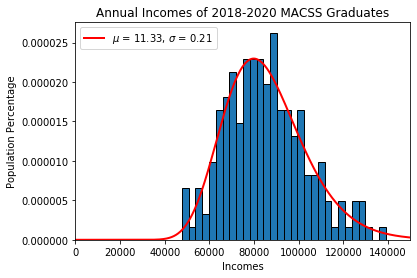

In [11]:
# Plot the estimated lognormal PDF against the histogram
num_bins = 30
count, bins, ignored = plt.hist(incomes, num_bins, density=True, edgecolor="k")
plt.title("Annual Incomes of 2018-2020 MACSS Graduates")
plt.xlabel(r"Incomes")
plt.ylabel(r"Population Percentage")
plt.xlim([1e-10, 150000])

dist_incomes = np.linspace(1e-10, 150000, 5000)
plt.plot(dist_incomes, trunc_lognormal_pdf(dist_incomes, mu_GMM1, sig_GMM1, 0, 150000), \
         lw=2, color="r", label=r"$\mu$ = {}, $\sigma$ = {}".format(round(mu_GMM1, 2), round(sig_GMM1, 2)))
         
plt.legend(loc="best");

**The two data moments and the two model moments are close up to the two decimal points.**

#### (c)

In [12]:
# Define a function that computes the R * N matrix of error from each observations for each moment
def get_Err_mat_2(xvals, mu, sigma, cut_lb, cut_ub, simple=False):
    R = 2
    N = len(xvals)
    Err_mat = np.zeros((R, N))
    mean_data, std_data = data_moments(xvals)
    mean_model, std_model = model_moments(mu, sigma, cut_lb, cut_ub)
    if simple:
        Err_mat[0, :] = xvals - mean_model
        Err_mat[1, :] = np.sqrt((mean_data - xvals) ** 2) - std_model
    else:
        Err_mat[0, :] = (xvals - mean_model) / mean_model
        Err_mat[1, :] = (np.sqrt((mean_data - xvals) ** 2) - std_model) / std_model
    return Err_mat

In [13]:
# Calculate the new estimate of the var.-cov. matrix
err_mat = get_Err_mat_2(incomes, mu_GMM1, sig_GMM1, cut_lb, cut_ub, simple=False)
N = incomes.shape[0]
VCV2 = 1 / N  * err_mat @ err_mat.T
print("The estimate for the var.-cov. matrix = \n", VCV2)

The estimate for the var.-cov. matrix = 
 [[0.04451671 0.02724079]
 [0.02724079 0.40593057]]


In [14]:
# Calculate the new optimal weighing matrix
W_hat2 = lin.inv(VCV2)
print("The two-step estimator for the optimal weighting matrix = \n", W_hat2)

The two-step estimator for the optimal weighting matrix = 
 [[23.42542598 -1.57201036]
 [-1.57201036  2.56896839]]


In [15]:
# Estimate the parameters of the lognormal dist. by two-step GMM
params_init = np.array([mu_GMM1, sig_GMM1])
cut_lb = 0.0
cut_ub = 150000.0
gmm_args2 = (incomes, cut_lb, cut_ub, W_hat2)
results2 = opt.minimize(criterion, params_init, args=gmm_args2, tol=1e-14, method="L-BFGS-B", bounds=((1e-10, None), (1e-10, None)))
mu_GMM2, sig_GMM2 = results2.x
print("mu_GMM2 = ", mu_GMM2)
print("sig_GMM2 = ", sig_GMM2)
results

mu_GMM2 =  11.333599603575983
sig_GMM2 =  0.21325529803982507


      fun: array([[6.39929185e-16]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.14975167e-08, -2.93651208e-08])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 45
      nit: 10
   status: 0
  success: True
        x: array([11.33359961,  0.2132553 ])

In [16]:
# Report the estimate results
mean_data, std_data = data_moments(incomes)
mean_model, std_model = model_moments(mu_GMM2, sig_GMM2, cut_lb, cut_ub)
err2 = err_vec(incomes, mu_GMM2, sig_GMM2, cut_lb, cut_ub, simple=False).reshape(2, )

print("Mean of the incomes = ", mean_data, ", s.t.d. of the incomes = ", std_data)
print("Mean of the model = ", mean_model, ", s.t.d. of the model = ", std_model)
print("Error Vector = ", err2)
print("Minimized value of the GMM criterion function = ", results.fun)

Mean of the incomes =  85276.82360625811 , s.t.d. of the incomes =  17992.542128046523
Mean of the model =  85276.8232751028 , s.t.d. of the model =  17992.541776223767
Error Vector =  [-3.88329796e-09 -1.95538104e-08]
Minimized value of the GMM criterion function =  [[6.39929185e-16]]


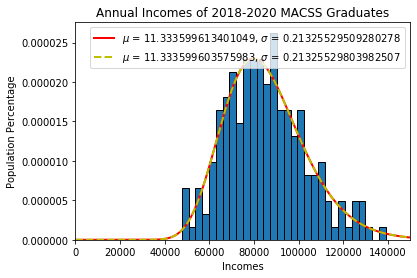

In [17]:
# Plot the estimated lognormal PDF against the histogram
num_bins = 30
count, bins, ignored = plt.hist(incomes, num_bins, density=True, edgecolor="k")
plt.title("Annual Incomes of 2018-2020 MACSS Graduates")
plt.xlabel(r"Incomes")
plt.ylabel(r"Population Percentage")
plt.xlim([1e-10, 150000])

dist_incomes = np.linspace(1e-10, 150000, 5000)
plt.plot(dist_incomes, trunc_lognormal_pdf(dist_incomes, mu_GMM1, sig_GMM1, 0, 150000), \
         lw=2, color="r", label=r"$\mu$ = {}, $\sigma$ = {}".format(mu_GMM1, sig_GMM1))

plt.plot(dist_incomes, trunc_lognormal_pdf(dist_incomes, mu_GMM2, sig_GMM2, 0, 150000), \
         lw=2, ls="--", color="y", label=r"$\mu$ = {}, $\sigma$ = {}".format(mu_GMM2, sig_GMM2))

plt.legend(loc="best");

**As before, the two data moments and the two model moments are very close.**

**And the two-step GMM estimation has very similar results with the previous estimation.**

#### (d) Three moments, identity weighting matrix

In [18]:
# Define a function that computes the three data moments for GMM
def data_moments3(xvals):
    N = xvals.shape[0]
    bpct_1_dat = xvals[xvals < 75000.0].shape[0] / N
    bpct_2_dat = xvals[(xvals >= 75000.0) & (xvals < 100000.0)].shape[0] / N
    bpct_3_dat = xvals[xvals > 100000.0].shape[0] / N
    return bpct_1_dat, bpct_2_dat, bpct_3_dat

In [19]:
# Define a function that compute the three model moments for GMM
def model_moments3(mu, sigma, cut_lb, cut_ub):
    xfx = lambda x: trunc_lognormal_pdf(x, mu, sigma, cut_lb, cut_ub)
    bpct_1_mod, bp_1_err = intgr.quad(xfx, 0.0, 75000.0)
    bpct_2_mod, bp_2_err = intgr.quad(xfx, 75000.0, 100000.0)
    bpct_3_mod, bp_3_err = intgr.quad(xfx, 100000.0, 150000.0)
    return bpct_1_mod, bpct_2_mod, bpct_3_mod

In [20]:
# Define the moment error function
def err_vec3(xvals, mu, sigma, cut_lb, cut_ub, simple):
    bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments3(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments3(mu, sigma, cut_lb, cut_ub)
    moms_mod = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])
    if simple:
        err_vec = moms_mod - moms_data
    else:
        err_vec = (moms_mod - moms_data) / moms_data
    return err_vec

In [21]:
def criterion3(params, *args):
    mu, sigma = params
    xvals, cub_lb, cut_ub, W = args
    err = err_vec3(xvals, mu, sigma, cut_lb, cut_ub, simple=False)
    crit_val = err.T @ W @ err
    return crit_val

In [22]:
# Estimate the params by 3-moment GMM
mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
cut_lb = 0.0
cut_ub = 150000.0
W_hat = np.eye(3)  # Generate the identity matrix
gmm_args3 = (incomes, cut_lb, cut_ub, W_hat)
results3 = opt.minimize(criterion3, params_init, args=gmm_args3, \
                        tol=1e-14, method="L-BFGS-B", bounds=((1e-10, None), (1e-10, None)))
mu_GMM3_1, sig_GMM3_1 = results3.x
print("mu_GMM3_1 = ", mu_GMM3_1)
print("sig_GMM3_1 = ", sig_GMM3_1)
results3

mu_GMM3_1 =  11.336705181100031
sig_GMM3_1 =  0.21151351584300565


      fun: array([[1.82841985e-15]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.72499409e-07, 7.61405060e-09])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 153
      nit: 22
   status: 0
  success: True
        x: array([11.33670518,  0.21151352])

In [23]:
# Report the estimate results
bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments3(mu_GMM3_1, sig_GMM3_1, cut_lb, cut_ub)
err3_1 = err_vec3(incomes, mu_GMM3_1, sig_GMM3_1, cut_lb, cut_ub, False)

print("Params = ", [mu_GMM3_1, sig_GMM3_1])
print("Data moments = ", data_moments3(incomes))
print("Model moments = ", model_moments3(mu_GMM3_1, sig_GMM3_1, cut_lb, cut_ub))
print("Error vector = \n", err3_1)
print("Minimized value of the GMM criterion function = ", results3.fun)

Params =  [11.336705181100031, 0.21151351584300565]
Data moments =  (0.3, 0.5, 0.2)
Model moments =  (0.3000000012519241, 0.5000000068113886, 0.19999999193668755)
Error vector = 
 [[ 4.17308040e-09]
 [ 1.36227771e-08]
 [-4.03165623e-08]]
Minimized value of the GMM criterion function =  [[1.82841985e-15]]


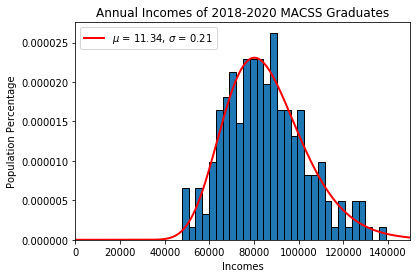

In [24]:
# Plot the estimated lognormal PDF against the histogram
num_bins = 30
count, bins, ignored = plt.hist(incomes, num_bins, density=True, edgecolor="k")
plt.title("Annual Incomes of 2018-2020 MACSS Graduates")
plt.xlabel(r"Incomes")
plt.ylabel(r"Population Percentage")
plt.xlim([1e-10, 150000])

dist_incomes = np.linspace(1e-10, 150000, 5000)
plt.plot(dist_incomes, trunc_lognormal_pdf(dist_incomes, mu_GMM3_1, sig_GMM3_1, 0, 150000), \
         lw=2, color="r", label=r"$\mu$ = {}, $\sigma$ = {}".format(round(mu_GMM3_1, 2), round(sig_GMM3_1, 2)))
         
plt.legend(loc="best");

#### (e) Three moments, two-step estimator for the optimal weighting matrix

In [25]:
# Define a function that computes the R * N matrix of error from each observations for each moment
def get_Err_mat_3(xvals, mu, sigma, cut_lb, cut_ub, simple=False):
    R = 3
    N = len(xvals)
    err_mat3 = np.zeros((R, N))
    income_group1 = xvals < 75000.0
    income_group2 = (xvals >= 75000.0) & (xvals <100000.0)
    income_group3 = xvals >= 100000.0
    bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments3(mu, sigma, cut_lb, cut_ub)
    if simple:
        err_mat3[0, :] = income_group1 - bpct_1_mod
        err_mat3[1, :] = income_group2 - bpct_2_mod
        err_mat3[2, :] = income_group3 - bpct_3_mod
    else:
        err_mat3[0, :] = (income_group1 - bpct_1_mod) / income_group1 
        err_mat3[1, :] = (income_group2 - bpct_2_mod) / income_group2
        err_mat3[2, :] = (income_group3 - bpct_3_mod) / income_group3
    return err_mat3

In [26]:
# Calculate the new estimate of the var.-cov. matrix
err_mat3 = get_Err_mat_3(incomes, mu_GMM3_1, sig_GMM3_1, cut_lb, cut_ub, simple=True)
N = incomes.shape[0]
VCV3_2 = 1 / N  * err_mat3 @ err_mat3.T
print("The estimate for the var.-cov. matrix = \n", VCV3_2)

The estimate for the var.-cov. matrix = 
 [[ 0.21 -0.15 -0.06]
 [-0.15  0.25 -0.1 ]
 [-0.06 -0.1   0.16]]


In [27]:
# Calculate the new optimal weighing matrix
W_hat3_2 = lin.pinv(VCV3_2)
print("The two-step estimator for the optimal weighting matrix = \n", W_hat3_2)

The two-step estimator for the optimal weighting matrix = 
 [[ 2.25925926 -0.62962963 -1.62962963]
 [-0.62962963  1.81481481 -1.18518519]
 [-1.62962963 -1.18518519  2.81481481]]


In [28]:
# Estimate the params by 3-moment two-step GMM
mu_init = 11
sig_init = 0.2
params_init = np.array([mu_init, sig_init])
cut_lb = 0.0
cut_ub = 150000.0
gmm_args3_2 = (incomes, cut_lb, cut_ub, W_hat3_2)
results3_2 = opt.minimize(criterion3, params_init, args=gmm_args3_2, \
                          tol=1e-14, method="L-BFGS-B", bounds=((1e-10, None), (1e-10, None)))
mu_GMM3_2, sig_GMM3_2 = results3_2.x
print("mu_GMM3_2 = ", mu_GMM3_2)
print("sig_GMM3_2 = ", sig_GMM3_2)
results3_2

mu_GMM3_2 =  11.33670517977796
sig_GMM3_2 =  0.21151351746070032


      fun: array([[7.9821992e-15]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([2.26794122e-08, 1.05839759e-08])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 120
      nit: 14
   status: 0
  success: True
        x: array([11.33670518,  0.21151352])

In [29]:
# Report the estimate results
bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments3(mu_GMM3_2, sig_GMM3_2, cut_lb, cut_ub)
err3_2 = err_vec3(incomes, mu_GMM3_2, sig_GMM3_2, cut_lb, cut_ub, False)

print("Params = ", [mu_GMM3_2, sig_GMM3_2])
print("Data moments = ", data_moments3(incomes))
print("Model moments = ", model_moments3(mu_GMM3_2, sig_GMM3_2, cut_lb, cut_ub))
print("Error vector = \n", err3_2)
print("Minimized value of the GMM criterion function = ", results3_2.fun)

Params =  [11.33670517977796, 0.21151351746070032]
Data moments =  (0.3, 0.5, 0.2)
Model moments =  (0.3000000048727936, 0.5000000032639967, 0.19999999186320977)
Error vector = 
 [[ 1.62426454e-08]
 [ 6.52799348e-09]
 [-4.06839512e-08]]
Minimized value of the GMM criterion function =  [[7.9821992e-15]]


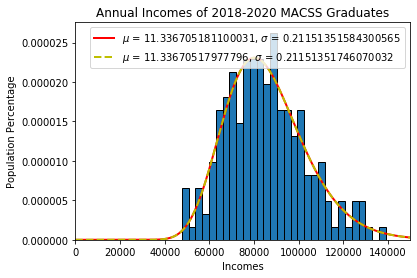

In [30]:
# Plot the estimated lognormal PDF against the histogram
num_bins = 30
count, bins, ignored = plt.hist(incomes, num_bins, density=True, edgecolor="k")
plt.title("Annual Incomes of 2018-2020 MACSS Graduates")
plt.xlabel(r"Incomes")
plt.ylabel(r"Population Percentage")
plt.xlim([1e-10, 150000])

dist_incomes = np.linspace(1e-10, 150000, 5000)
plt.plot(dist_incomes, trunc_lognormal_pdf(dist_incomes, mu_GMM3_1, sig_GMM3_1, 0, 150000), \
         lw=2, color="r", label=r"$\mu$ = {}, $\sigma$ = {}".format(mu_GMM3_1, sig_GMM3_1))
plt.plot(dist_incomes, trunc_lognormal_pdf(dist_incomes, mu_GMM3_2, sig_GMM3_2, 0, 150000), \
         lw=2, ls="--", color="y", label=r"$\mu$ = {}, $\sigma$ = {}".format(mu_GMM3_2, sig_GMM3_2))

plt.legend(loc="best");

**As before, the four data moments and the four model moments are very close up to the 8th decimal points.**

**And the four-moment two-step GMM estimation has very similar results with the previous four-moment GMM estimation.**

#### (f)

In [31]:
method = ["2 Moments with Identity",
          "2 Moments with 2-step",
          "3 Moments with Identity",
          "3 Moments with 2-step"]
mu_list = [mu_GMM1, mu_GMM2, mu_GMM3_1, mu_GMM3_2]
sig_list = [sig_GMM1, sig_GMM2, sig_GMM3_1, sig_GMM3_2]
val_list = [results.fun, results2.fun, results3.fun, results3_2.fun]

pd.DataFrame(index=method, data={"mu": mu_list,
                                 "sig": sig_list,
                                 "Criterion Function Value": val_list}).astype(float)

,mu,sig,Criterion Function Value
2 Moments with Identity,11.333600,0.213255,6.399292e-16
2 Moments with 2-step,11.333600,0.213255,1.096769e-15
3 Moments with Identity,11.336705,0.211514,1.828420e-15
3 Moments with 2-step,11.336705,0.211514,7.982199e-15


**Generally speaking, the GMM estimations are very similar to each other up to the 15th decimal. The GMM model using 2 moments and identity matrix, i.e. model (b) fits the data best because it has the smallest value of the criterion function.**

### Question 2

#### (a)

In [32]:
# Load the sick data as dataframe
df = pd.read_csv("data/sick.txt").astype(float)
df.head()

,sick,age,children,avgtemp_winter
0,1.67,57.47,3.04,54.10
1,0.71,26.77,1.20,36.54
2,1.39,41.85,2.31,32.38
3,1.37,51.27,2.46,52.94
4,1.45,44.22,2.72,45.90


In [33]:
# Define the moment error function
def get_err_vec(df, b0, b1, b2, b3):
    err_vec = df["sick"] - b0 - b1 * df["age"] - b2 * df["children"] - b3 * df["avgtemp_winter"]
    return err_vec

In [34]:
# Define the criterion function
def criterion2(params, *args):
    b0, b1, b2, b3 = params
    df, W = args
    err = get_err_vec(df, b0, b1, b2, b3)
    crit_val = err.T @ W @ err
    return crit_val

In [35]:
# Perform the GMM estimation
b0_init = 0.25
b1_init = 0.01
b2_init = 0.4
b3_init = -0.01
params_init2 = np.array([b0_init, b1_init, b2_init, b3_init])
W2 = np.eye(200)  # Generate the identity matrix
gmm_args2 = (df, W2)
results2 = opt.minimize(criterion2, params_init2, args=gmm_args2, method="L-BFGS-B", tol=1e-14)
b0_gmm, b1_gmm, b2_gmm, b3_gmm = results2.x
crit_val2 = results2.fun
print("GMM Estimation Result: \n")
for i, b in zip(range(4), results2.x):
    print("beta_{}".format(i),"\t", b)
print("\nGMM Criterion Function Value: ", crit_val2)

GMM Estimation Result: 

beta_0 	 0.2516442904858059
beta_1 	 0.012933508116342512
beta_2 	 0.40050074873123154
beta_3 	 -0.009991722821041306

GMM Criterion Function Value:  0.0018212897399234773
